# WCS

Switch to using `astropy` WCS pixelizations + `astropy-healpix` utility functions for plotting. Possibly also depending on `reproject` for conversions at fixed resolutions, though this might be inefficient depending on how it handles partial skymaps.

## Links

- [`reproject` example](https://reproject.readthedocs.io/en/stable/healpix.html)
- [WCS Supported projections](https://docs.astropy.org/en/stable/wcs/supported_projections.html)
  - [`astropy` WCS reference](https://docs.astropy.org/en/stable/wcs/reference_api.html#module-astropy.wcs)
    - [WCS FITS documentation](https://fits.gsfc.nasa.gov/fits_wcs.html)
      - [FITS Standard PDF](https://fits.gsfc.nasa.gov/standard40/fits_standard40aa-le.pdf)
  - [`astropy` WCS examples](https://docs.astropy.org/en/stable/wcs/index.html)
    - [Building custom WCS instances](https://docs.astropy.org/en/stable/wcs/example_create_imaging.html)
    - [*Learning from Fits* paper](https://ui.adsabs.harvard.edu/abs/2015A%26C....12..133T/abstract)
- [Coordinate systems primer](https://adl1995.github.io/an-introduction-to-coordinate-systems-used-in-astronomy.html)
- [Interpolating using `astropy-healpix`](https://astropy-healpix.readthedocs.io/en/latest/interpolation.html)

In [6]:
import healpy as hp
import astropy_healpix.healpy as ahp
from astropy_healpix import HEALPix
from hpmoc.healpy import healpy as hhp
from matplotlib import pyplot as plt, cm
import numpy as np
import hpmoc
from hpmoc.partial import PartialUniqSkymap
from reproject import reproject_from_healpix, reproject_to_healpix
import astropy as ap
from astropy.wcs import WCS
from astropy.io import fits
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.coordinates import FK5

In [2]:
m = PartialUniqSkymap.read("../tests/data/S191216ap.fits.gz", strategy='ligo')
mo = PartialUniqSkymap.read("../tests/data/S191216ap.multiorder.fits", strategy='ligo')
mc = (m.s⃗*m.A⃗()).value

In [3]:
hdu_ligo = fits.open("../tests/data/S191216ap.fits.gz")[1]
target_header = fits.Header.fromstring("""
NAXIS   =                    2
NAXIS1  =                  480
NAXIS2  =                  240
CTYPE1  = 'RA---MOL'
CRPIX1  =                240.5
CRVAL1  =                180.0
CDELT1  =               -0.675
CUNIT1  = 'deg     '
CTYPE2  = 'DEC--MOL'
CRPIX2  =                120.5
CRVAL2  =                  0.0
CDELT2  =                0.675
CUNIT2  = 'deg     '
COORDSYS= 'icrs    '
""", sep='\n')
w = WCS(target_header)

In [4]:
mo.render(w)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [128]:
sk = w.pixel_to_world([[0], [239], [479]], [120, 121])

In [129]:
sk.dec.rad

array([[0.00530331, 0.01591016],
       [0.00530331, 0.01591016],
       [0.00530331, 0.01591016]])

In [121]:
w.pixel_to_world?

In [130]:
sk2 = w.pixel_to_world(*np.meshgrid(*map(np.arange, w.array_shape), indexing='ij', sparse=True))

In [135]:
isinstance(w, WCS)

True

In [132]:
ra = sk2.ra.deg
dec = sk2.dec.deg
del sk2
ra_valid = ~np.isnan(ra)
dec_valid = ~np.isnan(dec)
assert np.all(ra_valid == dec_valid)
del dec_valid
#print(ra_valid.shape)
inds = ahp.ang2pix(256, ra, dec, lonlat=True)

array([[    -1,     -1,     -1, ...,     -1,     -1,     -1],
       [    -1,     -1,     -1, ...,     -1,     -1,     -1],
       [    -1,     -1,     -1, ...,     -1,     -1,     -1],
       ...,
       [786305, 785712, 784976, ...,     -1,     -1,     -1],
       [786271, 785711, 784975, ...,     -1,     -1,     -1],
       [786270, 785710, 784974, ...,     -1,     -1,     -1]])

In [7]:
from hpmoc.utils import resol2nside, nest2uniq, render
from hpmoc.healpy import healpy as hp
from hpmoc.abstract import AbstractPartialUniqSkymap


def wcs_resol(wcs: WCS):
    from astropy.units import Unit

    return min(abs(d)*Unit(u) for d, u in zip(wcs.wcs.cdelt, wcs.wcs.cunit))


def render_wcs(s⃗, wcs: WCS):
    from astropy.units import Quantity as Qty

    sk = wcs.pixel_to_world(*np.meshgrid(*map(np.arange, wcs.pixel_shape),
                                         sparse=True))
    ra = sk.ra.deg
    dec = sk.dec.deg
    del sk
    ra_valid = ~np.isnan(ra)
    dec_valid = ~np.isnan(dec)
    assert np.all(ra_valid == dec_valid)
    del dec_valid

    if isinstance(s⃗, AbstractPartialUniqSkymap):
        nest = True
        nˢ = resol2nside(wcs_resol(wcs).to('rad').value, degrees=False)
    else:
        nˢ = hp.npix2nside(len(s⃗))
    ṡ = hp.ang2pix(nˢ, ra[ra_valid], dec[ra_valid], lonlat=True, nest=nest)

    if isinstance(s⃗, AbstractPartialUniqSkymap):
        s⃗ = s⃗.value.render(nest2uniq(ṡ, nˢ, in_place=True),
                           pad=np.nan, copy=False).s⃗
    else:
        if isinstance(s⃗, Qty):
            s⃗ = s⃗.value
        s⃗ = s⃗[s⃗̇]
    del ṡ
    
    s⃗ₒ = np.full(wcs.array_shape, np.nan)
    s⃗ₒ[ra_valid] = s⃗
    return s⃗ₒ


def render_pus(s⃗: PartialUniqSkymap, wcs: WCS):
    from astropy.units import Quantity as Qty

    sk = wcs.pixel_to_world(*np.meshgrid(*map(np.arange, wcs.pixel_shape),
                                         sparse=True))
    ra = sk.ra.deg
    dec = sk.dec.deg
    del sk
    ra_valid = ~np.isnan(ra)
    dec_valid = ~np.isnan(dec)
    assert np.all(ra_valid == dec_valid)
    del dec_valid

    nˢ = resol2nside(wcs_resol(wcs).to('rad').value, degrees=False)
    s⃗ = s⃗.value.render(
        nest2uniq(
            hp.ang2pix(nˢ, ra[ra_valid], dec[ra_valid], lonlat=True, nest=True),
            nˢ,
            in_place=True
        ),
        pad=np.nan,
        copy=False
    ).s⃗

    s⃗ₒ = np.full(wcs.array_shape, np.nan)
    s⃗ₒ[ra_valid] = s⃗
    return s⃗ₒ

def wcs2mask_and_uniq(wcs: WCS):
    from astropy.units import Quantity as Qty
    import numpy as np

    sk = wcs.pixel_to_world(*np.meshgrid(*map(np.arange, wcs.pixel_shape),
                                         sparse=True))
    ra = sk.ra.deg
    dec = sk.dec.deg
    del sk
    ra_valid = ~np.isnan(ra)
    dec_valid = ~np.isnan(dec)
    assert np.all(ra_valid == dec_valid)
    del dec_valid

    nˢ = resol2nside(wcs_resol(wcs).to('rad').value, degrees=False)
    return ra_valid, nest2uniq(
        hp.ang2pix(nˢ, ra[ra_valid], dec[ra_valid], lonlat=True, nest=True),
        nˢ,
        in_place=True
    )

In [256]:
wcs2mask_and_uniq(w)

(array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 array([245776, 245765, 245765, ...,  81914,  81914,  81903]))

In [215]:
np.full_like?

In [205]:
min(abs(d)*Unit(u) for d, u in zip(w.wcs.cdelt, w.wcs.cunit)).to('rad').value

0.011780972450961725

In [201]:
r

0.675

In [166]:
max(map(abs, np.linalg.eig(w.pixel_scale_matrix)[0]))

0.675

In [156]:
w.to_header()

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                240.5 / Pixel coordinate of reference point            
CRPIX2  =                120.5 / Pixel coordinate of reference point            
CDELT1  =               -0.675 / [deg] Coordinate increment at reference point  
CDELT2  =                0.675 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---MOL'           / Right ascension, Mollweide's projection        
CTYPE2  = 'DEC--MOL'           / Declination, Mollweide's projection            
CRVAL1  =                180.0 / [deg] Coordinate value at reference point      
CRVAL2  =                  0.0 / [deg] Coordinate value at reference point      
LONPOLE =                  0.0 / [deg] Native longitude of celestial pole       
LATPOLE =                 90

In [155]:
w.to_header()['CDELT1']

-0.675

In [134]:
ra.shape

(240, 480)

In [140]:
array.shape

(240, 480)

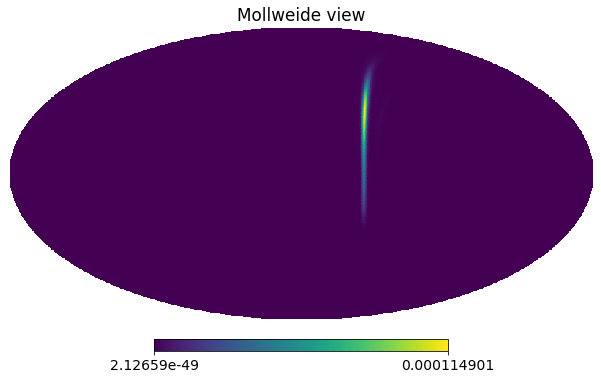

In [50]:
hp.mollview(mc, nest=True)

In [36]:
np.meshgrid(3,2)

[array([[3]]), array([[2]])]

In [41]:
ra

array([[         nan,          nan,          nan, ..., 199.74338362,
        191.84603017, 183.94867672],
       [         nan,          nan,          nan, ..., 191.73094591,
        187.03856755, 182.34618918],
       [         nan,          nan,          nan, ..., 189.15607602,
        185.49364561, 181.8312152 ],
       ...,
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan]])

In [23]:
EllipticalFrame?

In [24]:
astro

NameError: name 'ap' is not defined

In [31]:
ap.visualization.wcsaxes.frame.BaseFrame?

In [30]:
EllipticalFrame.__base__

astropy.visualization.wcsaxes.frame.BaseFrame

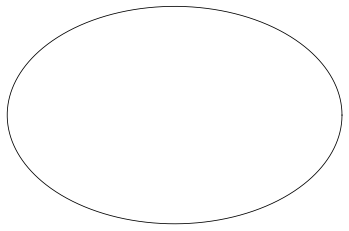

In [32]:
ax = plt.subplot(1,1,1, projection=w,
                 frame_class=EllipticalFrame)
ax.imshow(array, vmin=0, vmax=1.e-8)

In [59]:
array, footprint = reproject_from_healpix((mc, FK5()),
                                          target_header, nested=True)

In [63]:
array[120,60]

1.7375203306441513e-07

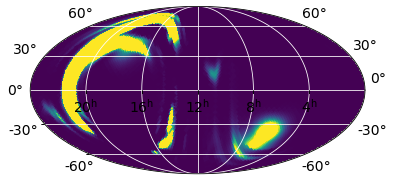

In [71]:
ax = plt.subplot(1,1,1, projection=WCS(target_header),
                 frame_class=EllipticalFrame)
ax.imshow(array, vmin=-1e-20, vmax=1.e-8)
ax.coords.grid(color='white')

In [72]:
array2, footprint2 = reproject_from_healpix("../tests/data/S191216ap.fits.gz",
                                          target_header, nested=True)

/Users/s/anaconda3/envs/hpmoc-dev/lib/python3.7/site-packages/astropy_healpix/core.py:516: RuntimeWarning: invalid value encountered in bilinear_interpolation_weights
  result = _core.bilinear_interpolation_weights(lon, lat, nside)
/Users/s/anaconda3/envs/hpmoc-dev/lib/python3.7/site-packages/astropy_healpix/core.py:481: RuntimeWarning: invalid value encountered in ring_to_nested
  return _core.ring_to_nested(ring_index, nside)


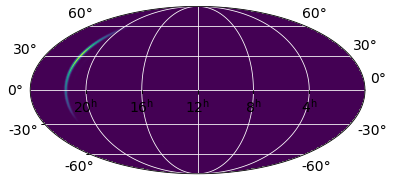

In [246]:
ax = plt.subplot(1,1,1, projection=WCS(target_header),
                 frame_class=EllipticalFrame)
ax.imshow(array2, vmin=-1e-20)
ax.coords.grid(color='white')

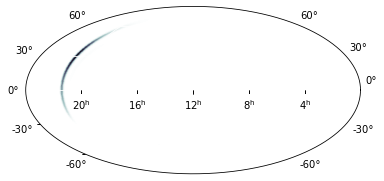

In [5]:
from matplotlib import cm

mor = mo.render(w)
ax = plt.subplot(1,1,1, projection=WCS(target_header),
                 frame_class=EllipticalFrame)
ax.imshow(mor, vmin=-1e-10, cmap=cm.bone_r)
ax.coords.grid(color='white')

0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<Figure size 1200x800 with 0 Axes>

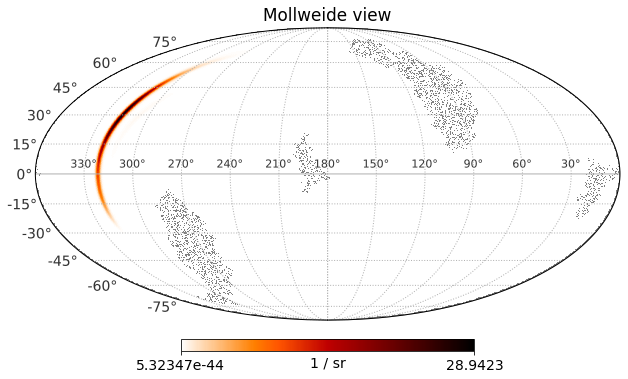

In [5]:
mo.mollview()

In [230]:
mor.shape

(240, 480)

In [231]:
array.shape

(240, 480)

In [7]:
h = HEALPix(nside=2, order='nested')

In [ ]:
h.interpolate_bilinear_lonlat([0, 1, 2, 3], [0, 1, 2, 3]

In [ ]:
hp.pixelfunc.get_all_neighbours

In [9]:
mo.reraster?

0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<Figure size 1200x800 with 0 Axes>

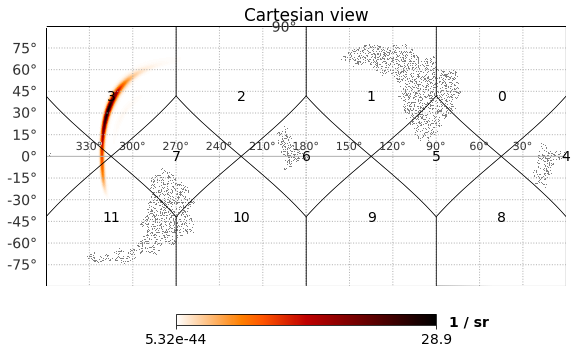

In [10]:
#fig = plt.figure(figsize=(2, 2))
mo.cartview()
ax = plt.gca()
ns = 1
for i in range(12*ns**2):
    θ, ϕ = hp.pix2ang(ns, i, nest=True)
    ax.projtext(θ, ϕ, str(i), ha='center', va='center')
    ax.projplot(hp.vec2ang(hp.boundaries(ns, i, 256, True).transpose()), 'k', linewidth=.5, zorder=10)